# A simple model for the spread of infection

We build an agent-based model for the spread of infection within a "well-mixed" population.

The population consists of a list of 'humans', each with status `:susceptible`, `:infected`, or `:removed`.

The model is initialized with

* `humans`: the population size
* `infected`: the initial number of infected people
* `contact_rate`: the number of people each individual contacts per day
* `infection_rate`: the probability of getting infected during contact
* `time_step`: the amount of time that passes between steps of the agent-based model

In [5]:
using Agents, Random, Distributions, PyPlot

Random.seed!(123);

mutable struct Human <: AbstractAgent
           id :: Int 
       status :: Symbol # :susceptible, :infected, or :removed
    infection :: Float64
end

agent_properties = [:status, :infection]

function SIRModel(;
                              humans = 1000,         # Number of susceptible
                            infected = 10,           # Number of infected
                        contact_rate = 6.0,          # people / day
                      infection_rate = 0.01,         # probability of infection upon contact
                           time_step = 1/24          # days
                  )   

    model_properties = Dict(
                            :contact_rate   => contact_rate,
                            :infection_rate => infection_rate,
                            :humans         => humans,
                            :infected       => infected,
                            :p_infection    => 0.0,
                            :time_step      => time_step,
                           )   

    model = ABM(Human, scheduler=fastest, properties=model_properties)

    # Initialize susceptible population
    susceptible = humans - infected

    for i = 1:susceptible
        add_agent!(model, :susceptible, 0.0)
    end 

    # Initialize infected population
    for i = 1:infected
        add_agent!(model, :infected, 0)
    end 

    return model
end

model = SIRModel(); # test whether function works...

# Model implementation

The implementation of a model in `Agents.jl` is expressed by the `agent_step!` and `model_step!` functions.

## The agent-based rule

The `agent_step!(agent, model)` function is looped over all agents.
We first check the status of the agent.
At the moment, we do nothing if `agent.status === :removed`; if `agent.status === :infected`, we simply increase the time since infection.

### A model for infection of susceptible agents

If the `agent.status === :infected`, we model the random number of infected people contacted by the agent with a Poisson process:

$$ C \sim \mathrm{Poisson} \left (\frac{r \Delta t I}{N} \right ) $$

where $C$ is the number of people contacted by each agent, $r$ is the contact rate, $\Delta t$ is the time interval in question, $I$ is the number of infected, and $N$ is the total population size.

We then calculate the probability of being infected, $p_i$, through contact with $C$ individuals as

$$ p_i = 1 - (1 - p_c)^C $$

where $p_c$ is the probability of infection during contact.
This is equivalent to calculating the probability of *failure* to be infected, $q_i$, by forming 

$$ \rho_q(N) = \mathrm{Binomial}(C, 1-p_c) \, \implies \, q_i \equiv \rho_q(C)$$

and using $p_i = 1 - q_i$. 
Notice that $p_i \to 1$ as $C \to \infty$.

Finally, we perform a Bernoulli trial with probability $p_i$ to determine whether the agent gets infected.

This algorithm is implemented below.

## After a model step

We use the `model_step!` function to calculate the total number of infected at the end of a time step.

In [6]:
function agent_step!(agent, m)
    
    if agent.status == :removed
        return nothing
        
    elseif agent.status  == :susceptible
        
        # Define a probabilistic model that determines whether the 
        # agent becomes infected
        
        # The (random) number of infected people this agent contacts
        infected_fraction = m.infected / m.humans   
        contacted = rand(Poisson(m.contact_rate * m.time_step * infected_fraction))
        
        # The probability that a susceptible is infected...
        p_infected =  1 - (1 - m.infection_rate)^contacted
        
        if rand(Bernoulli(p_infected))
            agent.status = :infected
        end
        
    elseif agent.status == :infected
        
        agent.infection += m.time_step
        
        # agent may become removed
    end 

    return nothing
end

function model_step!(model)
    infected_agents = [x.status === :infected for x in values(model.agents)]
    model.properties[:infected] = sum(infected_agents)
    return nothing
end

function count_infected(data, step)
    infected = filter(x -> (x.step == step && x.status === :infected), data) 
    return size(infected, 1)
end

function count_infected(data)
    infected = filter(x -> x.status === :infected, data) 
    return size(infected, 1)
end

count_infected (generic function with 2 methods)

# Simulation

We conduct 3 realizations of 30-day simulations with initial infected equal to 1, 10, and 100.

In [19]:
function sir_simulation(; steps=30*24, kwargs...)

    model = SIRModel(; kwargs...)
    infected = zeros(steps+1)
    time = zeros(steps+1)
    
    infected[1] = model.infected
    time[1] = 0

    for i = 1:steps
        step_data = step!(model, agent_step!, model_step!, 1, agent_properties)
        infected[i+1] = model.infected
        time[i+1] = i * model.time_step
    end
    
    return (humans=model.humans, time=time, infected=infected)
end

linestyles = ("-", "--", ":")

results = []

for (j, initial_infected) in enumerate((16, 64, 256))
    for i = 1:3
        result = sir_simulation(        humans = 4096,             # number of people
                                      infected = initial_infected, # initial number of infected 
                                  contact_rate = 6,                # per day
                                infection_rate = 0.01,             # probability of infection during contact
                                     time_step = 1/24,             # time-step
                                         steps = 30 * 24
                                )
        push!(results, result)
    end
end

# Plot results

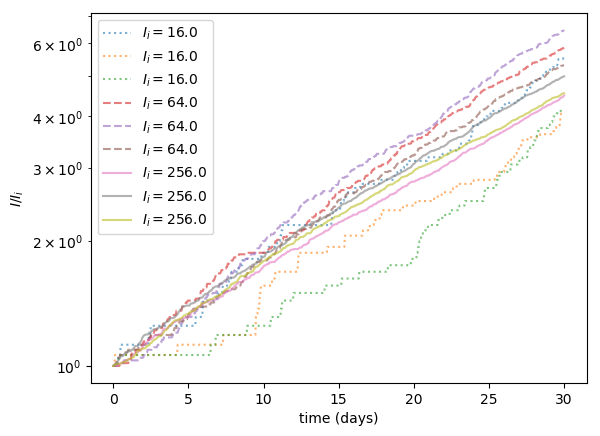

PyObject <matplotlib.legend.Legend object at 0x158c939e8>

In [24]:
# Unpack results

for result in results
    time = result.time
    infected = result.infected
    
    linestyle = infected[1] == 16 ? ":" :
                infected[1] == 64 ? "--" : "-"

    semilogy(time, infected / infected[1], linestyle,
             alpha=0.6, label="\$ I_i = $(infected[1]) \$")
    
    xlabel("time (days)")
    ylabel(L"I / I_i")
end

legend()